# Setup

### Dependencies

`
pip install --quiet --upgrade langchain-text-splitters langchain-community langgraph beautifulsoup4 langchain-google-genai langchain-huggingface langchain-chroma jupyter ipywidgets tqdm python-dotenv
`

### LangSmith

In [1]:
import os

from dotenv import load_dotenv

load_dotenv()

os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_API_KEY"] = os.getenv("LANGSMITH_API_KEY")

### Components

Chat Model: Google AI

In [2]:
os.environ["GOOGLE_API_KEY"] = os.getenv("GOOGLE_API_KEY")

In [3]:
from langchain_google_genai import ChatGoogleGenerativeAI

llm = ChatGoogleGenerativeAI(
    model="gemini-1.5-pro",
    temperature=0,
    max_tokens=None,
    timeout=None,
    max_retries=2,
    # other params...
)

D:\PycharmProjects\ChakraView\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
from langchain_huggingface import HuggingFaceEmbeddings

embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-mpnet-base-v2",
                                   cache_folder="huggingface_models")

Vector Store: Chroma

In [5]:
from langchain_chroma import Chroma

vector_store = Chroma(embedding_function=embeddings, persist_directory="chroma_db")

# Indexing

### Loading Documents

In [6]:
from langchain_community.document_loaders import TextLoader
from pathlib import Path

# Define the folder where your .txt files are stored
txt_folder = r"D:\Mahabharat Text"

# Load all .txt files from the folder
file_paths = list(Path(txt_folder).glob("*.txt"))

# Load documents
docs = [TextLoader(str(file_path)).load()[0] for file_path in file_paths]

# Print total character count from all files
total_chars = sum(len(doc.page_content) for doc in docs)
print(f"Total characters: {total_chars}")


Total characters: 14939870


In [7]:
print(docs[0].page_content[:1000])





The Mahabharata

of

Krishna-Dwaipayana Vyasa

BOOK 1

ADI PARVA

Translated into English Prose from the Original Sanskrit Text

by

Kisari Mohan Ganguli

[1883-1896]

Scanned at sacred-texts.com, 2003. Proofed at Distributed Proofing,
Juliet Sutherland, Project Manager. Additional proofing and formatting at
sacred-texts.com, by J. B. Hare.



TRANSLATOR'S PREFACE

The object of a translator should ever be to hold the mirror upto his
author. That being so, his chief duty is to represent so far as
practicable the manner in which his author's ideas have been expressed,
retaining if possible at the sacrifice of idiom and taste all the
peculiarities of his author's imagery and of language as well. In regard
to translations from the Sanskrit, nothing is easier than to dish up
Hindu ideas, so as to make them agreeable to English taste. But the
endeavour of the present translator has been to give in the following
pages as literal a rendering as possible of the great work of Vyasa. To
the 

### Splitting Documents

In [8]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,  # chunk size (characters)
    chunk_overlap=200,  # chunk overlap (characters)
    add_start_index=True,  # track index in original document
)
all_splits = text_splitter.split_documents(docs)

print(f"Split entire Mahabharat text into {len(all_splits)} sub-documents.")

Split entire Mahabharat text into 20885 sub-documents.


### Adding metadata

In [9]:
total_documents = len(all_splits)
third = total_documents // 3

for i, document in enumerate(all_splits):
    if i < third:
        document.metadata["section"] = "beginning"
    elif i < 2 * third:
        document.metadata["section"] = "middle"
    else:
        document.metadata["section"] = "end"

all_splits[0].metadata

{'source': 'D:\\Mahabharat Text\\maha01.txt',
 'start_index': 4,
 'section': 'beginning'}

### Storing documents

In [10]:
# Batch Insert Approach
batch_size = 1000

document_ids = []
for i in range(0, len(all_splits), batch_size):
    batch = all_splits[i:i + batch_size]
    batch_ids = vector_store.add_documents(documents=batch)
    document_ids.extend(batch_ids)
    print(f"Inserted {i + batch_size}/{len(all_splits)} documents")

print(document_ids[:3])

Inserted 1000/20885 documents
Inserted 2000/20885 documents
Inserted 3000/20885 documents
Inserted 4000/20885 documents
Inserted 5000/20885 documents
Inserted 6000/20885 documents
Inserted 7000/20885 documents
Inserted 8000/20885 documents
Inserted 9000/20885 documents
Inserted 10000/20885 documents
Inserted 11000/20885 documents
Inserted 12000/20885 documents
Inserted 13000/20885 documents
Inserted 14000/20885 documents
Inserted 15000/20885 documents
Inserted 16000/20885 documents
Inserted 17000/20885 documents
Inserted 18000/20885 documents
Inserted 19000/20885 documents
Inserted 20000/20885 documents
Inserted 21000/20885 documents
['3b2d83b2-3e04-475a-b020-bfc5e27577e2', '47308e2c-d97f-4724-9cee-e68012e37a63', 'fc9d59e8-6e8d-48fc-a67a-12746faa4e6b']


# Query Analysis

In [29]:
from typing import Literal
from pydantic import BaseModel, Field

class Search(BaseModel):
    """Search query."""
    query: str = Field(description="Search query to run.")
    section: Literal["beginning", "middle", "end"] = Field(description="Section to query.")

In [60]:
from langchain.prompts import PromptTemplate

custom_prompt = PromptTemplate(
    input_variables=["context", "question"],
    template="""
You are an expert AI assistant specializing in answering complex questions using retrieved context.
Your goal is to provide a detailed, structured, and well-formatted response with markdown elements.

### Question:
{question}

### Context:
{context}

### Answer:
- **Detailed Explanation:** Provide an in-depth response with supporting details.
- **Bullet Points & Formatting:** Use bullet points, subheadings, and code blocks when relevant.
- **Step-by-Step Breakdown:** If applicable, break down the answer into logical steps.
- **Examples & Analogies:** Where helpful, give real-world examples or analogies.

If the context does not contain enough information, state: "**The provided context does not have sufficient details.**"
""",
)

example_messages = custom_prompt.format(
    context="(context goes here)",
    question="(question goes here)"
)
print(example_messages)


You are an expert AI assistant specializing in answering complex questions using retrieved context.
Your goal is to provide a detailed, structured, and well-formatted response with markdown elements.

### Question:
(question goes here)

### Context:
(context goes here)

### Answer:
- **Detailed Explanation:** Provide an in-depth response with supporting details.
- **Bullet Points & Formatting:** Use bullet points, subheadings, and code blocks when relevant.
- **Step-by-Step Breakdown:** If applicable, break down the answer into logical steps.
- **Examples & Analogies:** Where helpful, give real-world examples or analogies.

If the context does not contain enough information, state: "**The provided context does not have sufficient details.**"



# Retrieval & Generation

### LangGraph

State

In [61]:
from langchain_core.documents import Document
from typing_extensions import List, TypedDict


class State(TypedDict):
    question: str
    query: Search
    context: List[Document]
    answer: str

Nodes

In [62]:
def analyze_query(state: State):
    structured_llm = llm.with_structured_output(Search)
    query = structured_llm.invoke(state["question"])
    return {"query": query}


def retrieve(state: State):
    query = state["query"]
    retrieved_docs = vector_store.similarity_search(
        query.query,
        filter={"section": query.section},
    )
    return {"context": retrieved_docs}


def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = custom_prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}

Control Flow

In [63]:
from langgraph.graph import START, StateGraph

graph_builder = StateGraph(State).add_sequence([analyze_query, retrieve, generate])
graph_builder.add_edge(START, "analyze_query")
graph = graph_builder.compile()

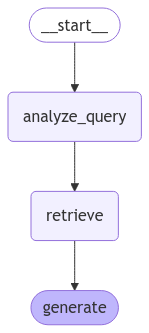

In [64]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

# Testing

In [65]:
result = graph.invoke({"question": "How has kurukshetra been described in the Mahabharata?"})

print(f'Context: {result["context"]}\n\n')
print(f'Answer: {result["answer"]}')

Context: [Document(id='cb6f3dcb-f664-450e-862b-d4e00d50b122', metadata={'section': 'beginning', 'source': 'D:\\Mahabharat Text\\maha03.txt', 'start_index': 519004}, page_content="By this, one obtaineth merit that is greater than that of a Rajasuya and\nhorse-sacrifices. The tirtha called Naimisha is productive of good on\nearth. Pushkara is productive of good in the regions of the firmament;\nKurukshetra, however, is productive of good in respect of all the three\nworlds. Even the dust of Kurukshetra, carried by the wind, leadeth sinful\nmen to a highly blessed state. They that reside in Kurukshetra, which\nlieth to the north of the Drishadwati and the south of the Saraswati,\nreally reside in heaven. 'I will go to Kurukshetra,' 'I will dwell in\nKurukshetra,' he that uttereth those words even once, becometh cleansed\nof all sins. The sacred Kurukshetra which is worshipped by Brahmarshis,\nis regarded as the sacrificial altar of the celestials. Those mortals\nthat dwell there, have not

In [71]:
for step in graph.stream(
        {"question": "How does the Mahabharata end?"}, stream_mode="updates"
):
    print(f"{step}\n\n----------------\n")

{'analyze_query': {'query': Search(query='How does the Mahabharata end?', section='end')}}

----------------

{'retrieve': {'context': [Document(id='f1582b95-e8b4-4179-9e60-2447547ac89a', metadata={'section': 'end', 'source': 'D:\\Mahabharat Text\\maha18.txt', 'start_index': 50454}, page_content='"I have thus, O chief of men, told everything in thy presence. He that\nlistens with devotion to this Bharata from the beginning becomes cleansed\nof every sin even if he be guilty of Brahmanicide or the violation of his\npreceptors bed, or even if he be a drinker of alcohol or a robber of\nother peoples wares, or even if he be born in the Chandala order.\nDestroying all his sins like the maker of day destroying darkness, such a\nman, without doubt, sports in felicity in the region of Vishnu like\nVishnu himself."\n\nThe End of the Svargarohanika-parva\n\nThe Eighteen parvas of the Mahabharata are thus complete'), Document(id='f0a8d4a4-6ba5-457e-b98d-21776ba50cc2', metadata={'section': 'end', 

In [68]:
for message, metadata in graph.stream(
        {"question": "How was Bhishma killed in the Mahabharata?"}, stream_mode="messages"
):
    print(message.content, end="|")

|Bh|ishma| was not directly killed by Sikhandin, but rather by Arjuna, with Sikhandin| serving as a crucial element in his downfall.  Here's a breakdown based on the provided| text:

* **Bhishma's Vow:**  The text doesn't explicitly detail the vow, but it alludes to Bhishma'|s inability to fight a woman.  Sikhandin, assigned female at birth but later identifying as male, presented a moral dilemma for Bhishma.

* **|The Role of Sikhandin:**  Bhishma refused to raise his weapons against Sikhandin due to this moral conflict.  Arjuna, recognizing this, positioned himself behind Sikhandin and used him as a shield.

* **|Arjuna's Attack:** With Bhishma defenseless, Arjuna showered him with arrows.  The text states, "Agreeably to Kshatriya duties, he was slain by Dhananjaya (Arjuna) on the field of battle while engaged| in battle."

* **Bhishma's Demise:**  Although pierced by numerous arrows, Bhishma did not die immediately.  He fell upon a bed of arrows and chose the time of his own passing